# SEL635/SEL5724 - Visão Computacional Aplicada a Robótica


**Aluno:** Felipe Gomes de Melo

**NUSP:** Preencher com seu número USP

Versão do documento: 1.0

**Importante:** A lista deve ser feita de forma individual!

# Lista 2 - Operações básicas com Imagens e Filtros de Ruído

Os objetivos principais desta lista de exercício são:
*   Realizar operações básicas com imagens;
*   Simular ruídos Gaussianos e impulsivos em imagens; 
*   Testar filtros Gaussianos e de Mediana;
*   Detacção de borda. 

**Não esqueça de conectar o Google Drive** no Colab usando o menu lateral, da mesma forma que foi feito na Lista 1.

In [2]:
# Carrega as bibliotecas para essa atividade
# from google.colab.patches import cv2_imshow # Necessário para mostrar imagens no Colab
import numpy as np
from matplotlib import pyplot as plt
import cv2
print(cv2.__version__) # Imprime a versão do OpenCV



4.4.0


## Parte A: Jogo dos 7 erros

As imagens a seguir possuem 7 regiões principais diferentes entre si.


<div>
<img src="https://drive.google.com/uc?id=1JkYaXcCSwPz7CquoX1T_YeXbuDmIHSEf" width="500"/>
<img src="https://drive.google.com/uc?id=1JjrwTbqoslqxLTiMMs0LK0N_KH7fxX2g" width="500"/>
</div>

Complete o código a seguir para gerar uma imagem colorida que ressalte em vermelho as principais diferenças entre as duas imagens. As regiões diferentes, devem aparecer em vermelho sobrepostas à uma das imagem originais.

Dica: Utilize as funções `cv2.absdiff`, `cv2.threshold`, `cv2.add`, `cv2.addWeighted`, e se preciso, as funções de operações lógicas bitwise `cv2.bitwise_and` e `cv2.bitwise_not`.


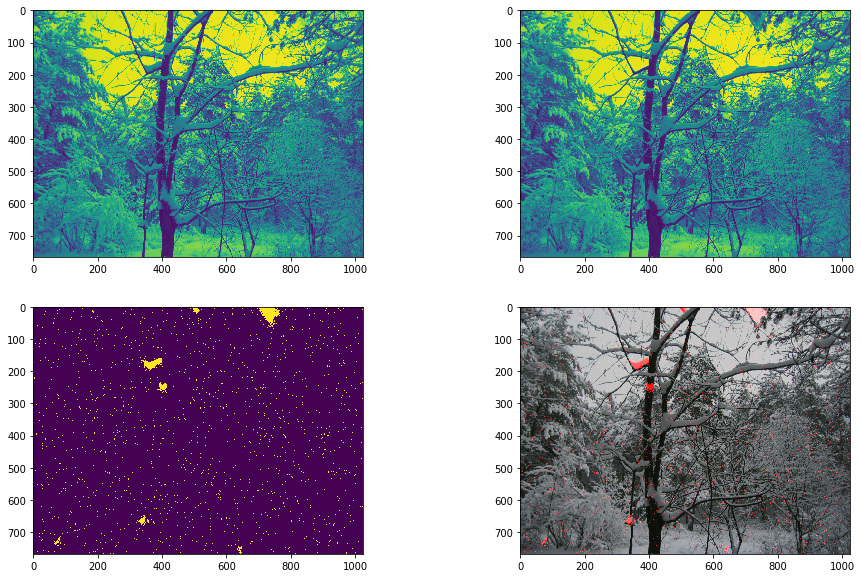

In [47]:
%matplotlib inline

plt.figure(figsize=(16,10))

plt.subplot(221)
img1 = cv2.imread('../imgs/forest_1.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img1) # Para precisar verificar se a imagem está sendo carregada, retirar o comentário da linha

plt.subplot(222)
img2 = cv2.imread('../imgs/forest_2.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img2)  # Para precisar verificar se a imagem está sendo carregada, retirar o comentário da linha

# # A imagem é carregada como sendo colorida para ter três canais de cores na sequencia BGR
img3 = cv2.imread('../imgs/forest_1.jpg',cv2.IMREAD_COLOR)
# # Cria uma imagem colorida vermelha do tamanho da imagem carregada
img4 = np.zeros(img3.shape,dtype=np.uint8)
img4[:,:,2] = 255

######## Complete o seu código aqui ########

noise_diff = np.abs(img1 - img2)
# diff = np.abs(img1 - img2)

_, diff = cv2.threshold(noise_diff, 50, 255, cv2.THRESH_BINARY)

plt.subplot(223)
plt.imshow(diff)

img4[:,:,2] = diff

# mask = np.multiply(diff.reshape((768,1024, 1)), img4)

plt.subplot(224)
plt.imshow(cv2.addWeighted(img4, 1, img3, 0.8, 0)[:,:,::-1])

##########################################

# A imagem img3 deve conter a imagem final com as regiões diferentes ressaltadas em vermelho
# cv2_imshow(img3)
plt.show()


## Parte B: Ruído Gaussiano

O rúido branco Gaussiano é um ruído aditivo com média $\mu=0$, e valor sorteado aleatóriamente segundo uma distribuição normal (Gaussiana) com desvio padrão $\sigma$. A densidade de probabilidade da distribuição Gaussiana é dada por:

$$ p(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-\mu)^2}{2\sigma^2}}$$

A função `adiciona_ruido_gaussiano(img, sigma)` definida a seguir, adiciona um ruido Gaussiano com desvio padrão $\sigma$ na imagem.

In [59]:
def adiciona_ruido_gaussiano(img,sigma):
    ruido = np.random.normal(0,sigma,img.shape)  # ruido é uma matriz da dimensão da imagem mas do tipo float64
    img_ruido = img+ruido # o resultado dessa soma será uma matriz do tipo float64
    #print(np.min(img1_ruido))
    #print(np.max(img1_ruido))
    img_ruido = np.clip(img_ruido, 0, 255) # Satura os valores para o intervalo entre 0 e 255
    #print(np.min(img1_ruido))
    #print(np.max(img1_ruido))
    return img_ruido.astype(np.uint8) # retorna os valores como tipo uint8


 Imagem original


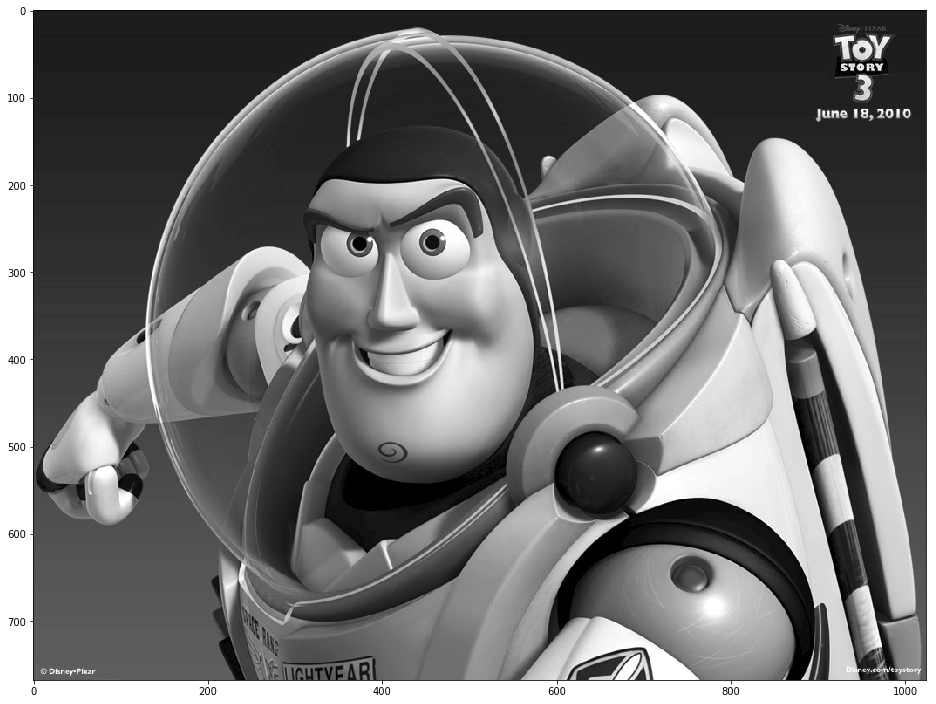

In [62]:
img1 = cv2.imread('../imgs/buzz_gray.png',cv2.IMREAD_GRAYSCALE)
print("\n Imagem original")

plt.figure(figsize=(16,18))
plt.imshow(img1, cmap='gray')

plt.show()


 Imagem com ruído sigma=10


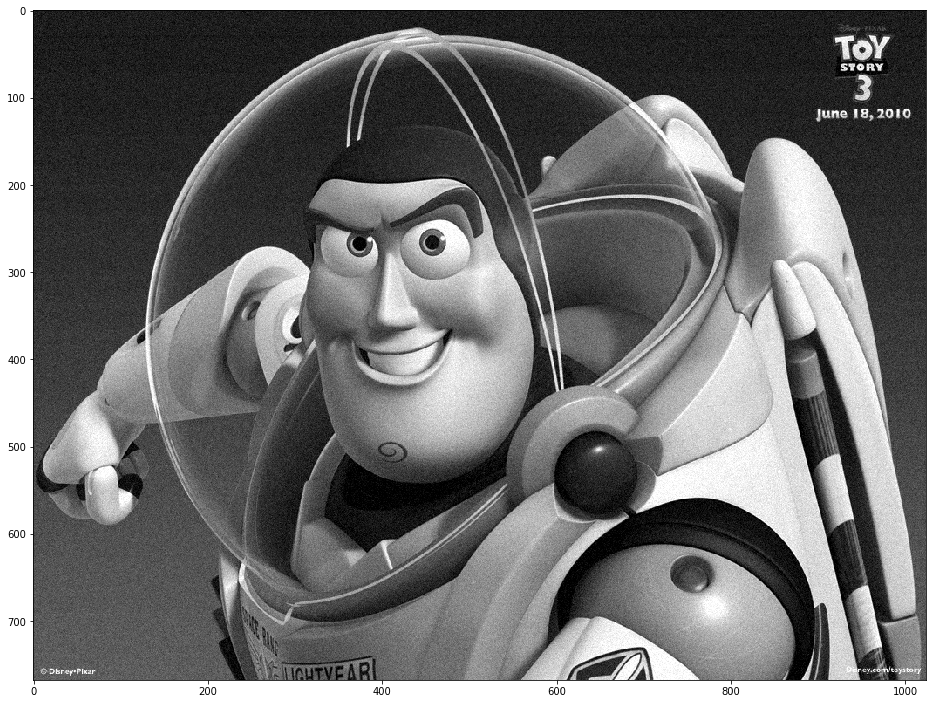

In [66]:
img1_ruido_1 = adiciona_ruido_gaussiano(img1,10)
print("\n Imagem com ruído sigma=10")

plt.figure(figsize=(16,18))
plt.imshow(img1_ruido_1, cmap='gray') # O OpenCV 

plt.show()


 Imagem com ruído sigma=20


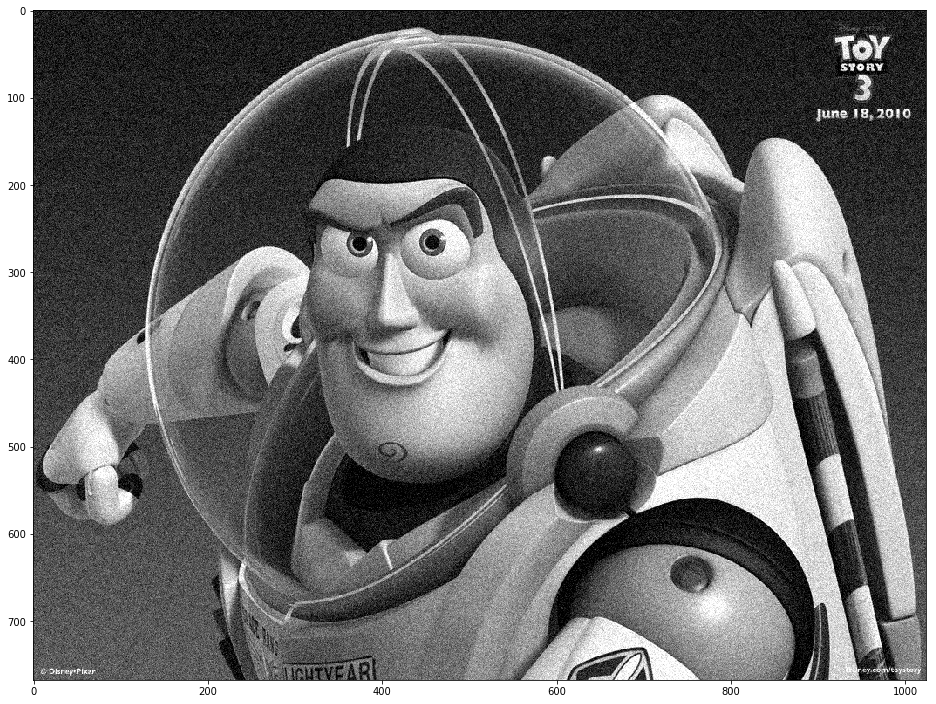

In [69]:
img1_ruido_2 = adiciona_ruido_gaussiano(img1,20)
print("\n Imagem com ruído sigma=20")

plt.figure(figsize=(16,18))
plt.imshow(img1_ruido_2, cmap='gray') # O OpenCV 

plt.show()

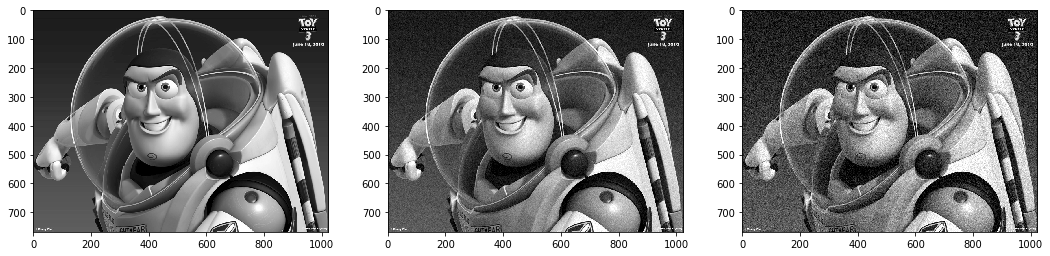

In [73]:
plt.figure(figsize=(18, 14))

plt.subplot(131)
plt.imshow(img1, cmap='gray')

plt.subplot(132)
plt.imshow(img1_ruido_1, cmap='gray')

plt.subplot(133)
plt.imshow(img1_ruido_2, cmap='gray')

plt.show()

## Parte C: Ruído Impulsivo

Implemente o código da função `adiciona_ruido_impulsivo(img, l, i_min, i_max)` conforme o algoritmo apresentado a seguir:

$$ f(x) = \begin{cases} 
f(x) & x < l\\
i_{min} + y (i_{max} - i_{min}) & x\geq l
\end{cases}$$
para $x,y \in [0,1]$ variáveis aleatórias uniformemente distribuídas.

In [84]:
def adiciona_ruido_impulsivo(img, l, i_min, i_max):
    # Amostra uma matriz x do tamanho da imagem com valores aleatórios uniformemente distribuidos
    x = np.random.uniform(0.0,1.0,img.shape)  
    # Cria uma máscara em que os valores (x<l) recebem true, os demais false. Então converte de boleano para inteiro (1 e 0, respectivamente).
    img_ruido_mask = (x<l).astype(np.uint8)
    # Multiplica imagem e mascara elemento por elemento
    img_ruido = np.multiply(img,img_ruido_mask).astype(np.float64)

    # Complete o código para terminar a definição de img_ruido
    ########################################################################
  
    complemento = np.ones(img_ruido_mask.shape) - img_ruido_mask
    y = np.random.uniform(0.0,1.0,img.shape)
    
    res = np.multiply(complemento, i_min+y*(i_max - i_min)).astype(np.float64)
    img_ruido += res
  
    ########################################################################

    img_ruido = np.clip(img_ruido, 0, 255) # Satura os valores para o intervalo entre 0 e 255
    return img_ruido.astype(np.uint8) # retorna os valores como tipo uint8


 Imagem com ruído impulsivo l=0.9


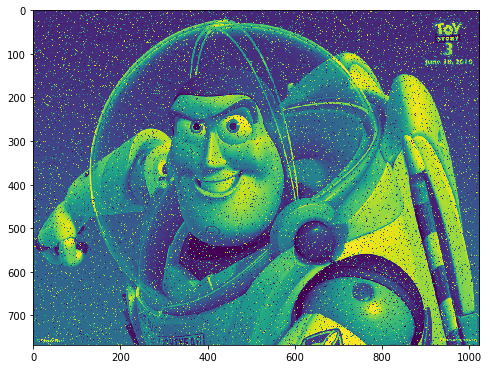

In [88]:
img1_ruido = adiciona_ruido_impulsivo(img1,0.9,0,255)
print("\n Imagem com ruído impulsivo l=0.9")

plt.figure(figsize=(8,9))
plt.imshow(img1_ruido)

plt.show()

## Parte D: Filtro Linear

A função `cv2.filter2D` da biblioteca OpenCV pode ser usada para fazer a convolução de uma imagem com um filtro 2D (kernel). A função implementada no OpenCV não faz o espelhamento do kernel em torno no seu centro. Dessa forma, se for preciso aplicar uma convolução real, é preciso fornecer o filtro espelhado como entrada da função. 

O código a seguir é um exemplo da implementação da função de convolução, e uma comparação com o resultado obtido pela função `cv2.filter2D`, ambas aplicando o filtro de média a uma matriz de teste. 

### Filtro de média

O código a seguir aplica o filtro de média na imagem sem ruído, imagem com ruído branco Gaussiano, e com ruído impulsivo.

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


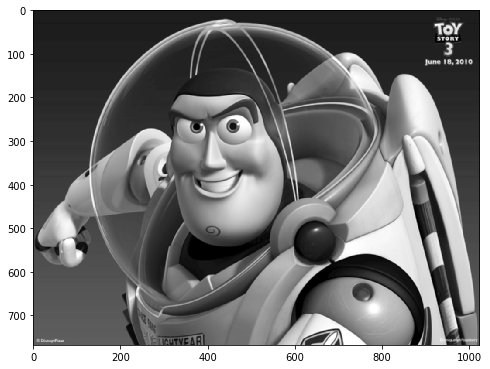

In [91]:
filtro_media = np.ones((3,3))/9
depth = 1
print(filtro_media)
img1_filtrada = cv2.filter2D(img1,-1,filtro_media)

plt.figure(figsize=(8,9))
plt.imshow(img1_filtrada, cmap='gray')

plt.show()

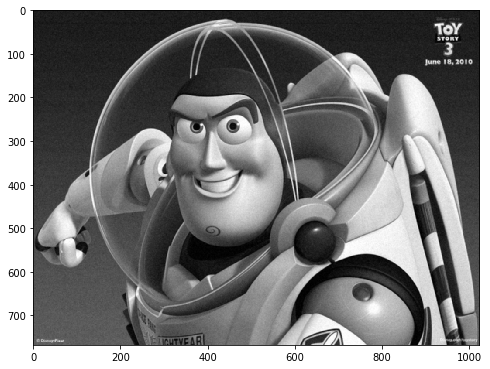

In [95]:
img1_ruido = adiciona_ruido_gaussiano(img1,10)
img1_filtrada = cv2.filter2D(img1_ruido,-1,filtro_media)

plt.figure(figsize=(8,9))
plt.imshow(img1_filtrada, cmap='gray')
plt.show()

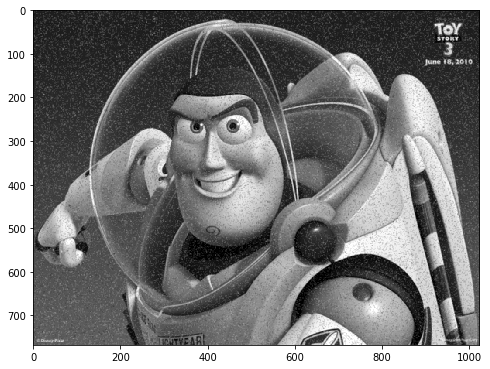

In [96]:
img1_ruido = adiciona_ruido_impulsivo(img1,0.9,0,255)
img1_filtrada = cv2.filter2D(img1_ruido,-1,filtro_media)

plt.figure(figsize=(8,9))
plt.imshow(img1_filtrada, cmap='gray')

plt.show()

### Filtro Gaussiano

O filtro Gaussiano 2D pode ser aplicado em duas passagens do filtro Gaussiano 1D. Na primeira passagem usando um filtro Gaussiano 1D horizontal e na segunda passagem o filtro Gaussiano 1D vertical, ou vice-versa.

Um exemplo de filtro Gaussiano 1D de dimensão 5 normalizado é dado por [1]:

$$ f = [1, 9, 18, 9, 1]/38$$

Complete o código a seguir para aplicar o filtro Gaussiano 1D nas mesmas imagens de teste do filtro pela média. Utilize a função `cv2.filter2D`. 

[1] E. Trucco, A. Verri. Introductory Techniques for 3D Computer Vision, Prentice Hall, 1998.

[0.02631579 0.23684211 0.47368421 0.23684211 0.02631579]
[[0.02631579]
 [0.23684211]
 [0.47368421]
 [0.23684211]
 [0.02631579]]


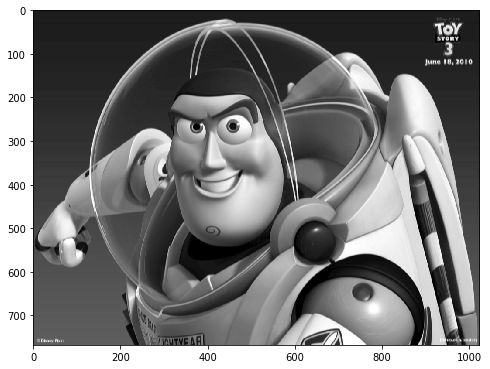

In [101]:
### Filtro Gaussiano do livro "E. Trucco, A. Verri. Introductory Techniques for 3D Computer Vision"
# O filtro deve ser normalizado para que a soma dos elementos seja 1
filtro_gaussiano_1d_h = np.array([1, 9, 18, 9, 1])/38  
print(filtro_gaussiano_1d_h)
filtro_gaussiano_1d_v = filtro_gaussiano_1d_h.reshape(5,1)
print(filtro_gaussiano_1d_v)

### Filtro calculado automaticamente pelo OpenCV
#filtro_gaussiano_1d_v = cv2.getGaussianKernel(5,-1)
#print(cv2.getGaussianKernel(5,-1))
#filtro_gaussiano_1d_h = filtro_gaussiano_1d_v.reshape(1,5)

#############################################################################
## Complete com o código de 2 linhas que aplica o filtro Gaussiano 1D na img1 
img1_quasi_filtrada = cv2.filter2D(img1, -1,filtro_gaussiano_1d_h)
img1_filtrada = cv2.filter2D(img1_quasi_filtrada, -1,filtro_gaussiano_1d_v)
#############################################################################

plt.figure(figsize=(8,9))
plt.imshow(img1_filtrada, cmap='gray')
plt.show()

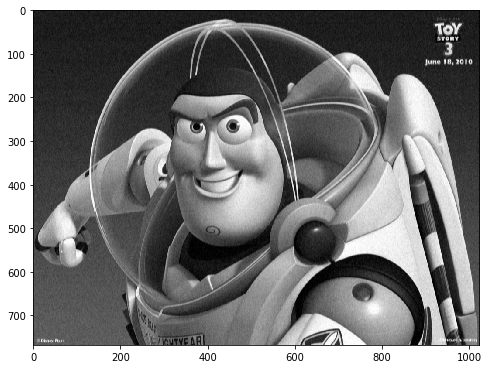

In [103]:
img1_ruido = adiciona_ruido_gaussiano(img1,10)
#############################################################################
## Complete com o código de 2 linhas que aplica o filtro Gaussiano 1D na img1_ruido 
img1_quasi_filtrada = cv2.filter2D(img1_ruido, -1,filtro_gaussiano_1d_h)
img1_filtrada = cv2.filter2D(img1_quasi_filtrada, -1,filtro_gaussiano_1d_v)
##################################################################################

plt.figure(figsize=(8,9))
plt.imshow(img1_filtrada, cmap='gray')
plt.show()

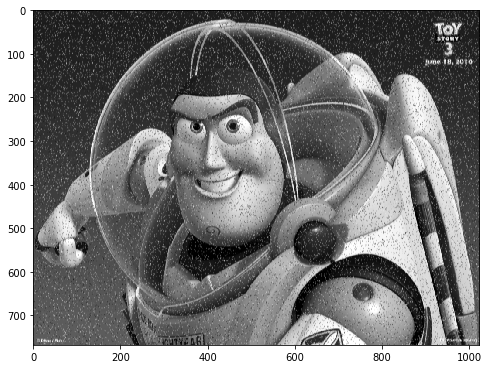

In [104]:
img1_ruido = adiciona_ruido_impulsivo(img1,0.9,0,255)
#############################################################################
## Complete com o código de 2 linhas que aplica o filtro Gaussiano 1D na img1_ruido 
img1_quasi_filtrada = cv2.filter2D(img1_ruido, -1,filtro_gaussiano_1d_h)
img1_filtrada = cv2.filter2D(img1_quasi_filtrada, -1,filtro_gaussiano_1d_v)
##################################################################################

plt.figure(figsize=(8,9))
plt.imshow(img1_filtrada, cmap='gray')
plt.show()

A biblioteca OpenCV possui a função `cv2.GaussianBlur` que aplica o filtro Gaussiano. A seguir um exemplo de como ela pode ser aplicada

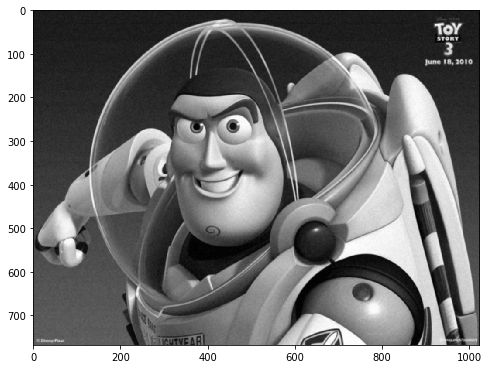

In [105]:
## Aplica o filtro Gaussiano de dimensão 5x5 com calculo automático do valor de sigma
img1_ruido = adiciona_ruido_gaussiano(img1,10)
img1_filtrada = cv2.GaussianBlur(img1_ruido,(5,5),0,0)
plt.figure(figsize=(8,9))
plt.imshow(img1_filtrada, cmap='gray')
plt.show()

### Filtro Não-linear usando Mediana

Ao aplicar o filtro usando a mediana, o pixel $g(x,y)$ da imagem filtrada será escolhido como sendo o valor mediano dos pixels dentro da região (ksize x ksize) centrada no pixel $f(x,y)$ da imagem original.

A função `cv2.medianBlur` implementa o filtro mediano. Não confundir o filtro mediano com o filtro pela média!

A seguir um exemplo da aplicação do filtro mediano na imagem original, imagem com ruído Gaussiano, e imagem com ruído impulsivo.


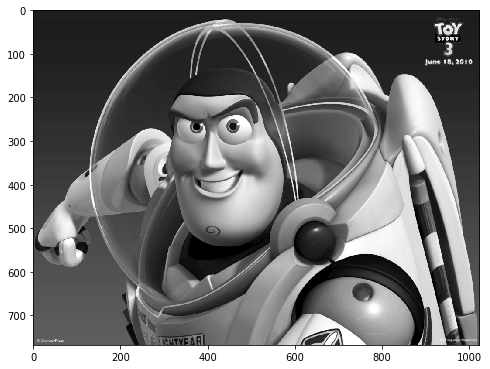

In [106]:
img1_filtrada = cv2.medianBlur(img1,3)
plt.figure(figsize=(8,9))
plt.imshow(img1_filtrada, cmap='gray')
plt.show()

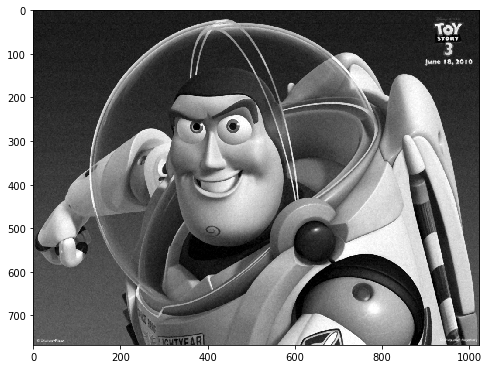

In [107]:
img1_ruido = adiciona_ruido_gaussiano(img1,10)
img1_filtrada = cv2.medianBlur(img1_ruido,3)
plt.figure(figsize=(8,9))
plt.imshow(img1_filtrada, cmap='gray')
plt.show()

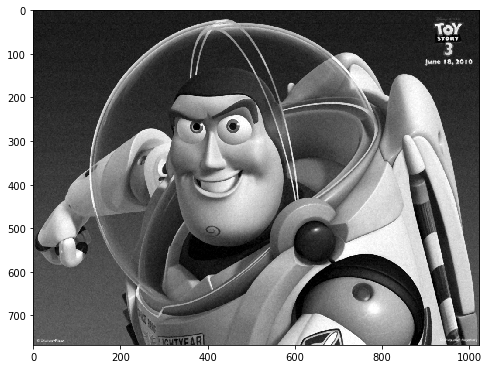

In [108]:
img1_ruido = adiciona_ruido_impulsivo(img1,0.9,0,255)
plt.figure(figsize=(8,9))
plt.imshow(img1_filtrada, cmap='gray')
plt.show()